# 2. Number of Parameters in Residule Net
+ Table 1 in the CVPR'16 paper explains the 50 layer ResNet, which is roughly grouped into conv1, conv2, conv3, conv4, conv5, and final pooling plus 1000 fully connected layer.
+ Please count how many parameters in conv1, conv2, conv3, conv4 and conv5, respectively. You can use Keras `model.count_parameters()' to verify your calculation.

In [0]:
from tensorflow import keras
import numpy as np

In [3]:
# assumed 3 channels of inputs
# conv1: layer [0,2)
# conv1 = conv + batch normolazation 
conv1 =(3*7*7*64+64)+4*64 #9472+256

# conv2: layer [2,22)

# conv2a = (input_depth_64*output_depth_64 + bias)            #1d_kernel_para
#         +(bn_paras_4*output_depth_64)                       #batch_normalization
#         +(input_depth*kernel_size*output_depth + bias)      #2d_kernel_para
#         +(bn_paras_4*output_depth_64)                       #batch_normalization
#         +(input depth*kernel_size*output_depth + bias)      #2d_kernel_para
#         +(bn_paras_4*output_depth_256)                      #batch_normalization
#         +(pre_layer_input depth_64*output_depth_256 + bias) #paras that change dimensions for skip connection
#         +(bn_paras_4*output_depth_256)                      #batch_normalization

# conv2 = conv2a+conv2b+conv2c
conv2a = ((64*64+64)+4*64) + ((64*3*3*64+64)+4*64) + ((64*256+256)+4*256+(64*256+256)+4*256)
conv2b = ((256*64+64)+4*64)+((64*3*3*64+64)+4*64)+((64*256+256)+4*256)
conv2c = ((256*64+64)+4*64)+((64*3*3*64+64)+4*64)+((64*256+256)+4*256)


# conv3: layer [22,48)
conv3a = ((256*128+128)+4*128)+((128*3*3*128+128)+4*128)+((128*512+512)+4*512+(256*512+512)+4*512)
conv3b = ((512*128+128)+4*128)+((128*3*3*128+128)+4*128)+((128*512+512)+4*512)
conv3c = ((512*128+128)+4*128)+((128*3*3*128+128)+4*128)+((128*512+512)+4*512)
conv3d = ((512*128+128)+4*128)+((128*3*3*128+128)+4*128)+((128*512+512)+4*512)

# conv4: layer [48,86)
conv4a = ((512*256+256)+4*256)+((256*3*3*256+256)+4*256)+((256*1024+1024)+4*1024+(512*1024+1024)+4*1024)
conv4b = ((1024*256+256)+4*256)+((256*3*3*256+256)+4*256)+((256*1024+1024)+4*1024)
conv4c = ((1024*256+256)+4*256)+((256*3*3*256+256)+4*256)+((256*1024+1024)+4*1024)
conv4d = ((1024*256+256)+4*256)+((256*3*3*256+256)+4*256)+((256*1024+1024)+4*1024)
conv4e = ((1024*256+256)+4*256)+((256*3*3*256+256)+4*256)+((256*1024+1024)+4*1024)
conv4f = ((1024*256+256)+4*256)+((256*3*3*256+256)+4*256)+((256*1024+1024)+4*1024)

# conv5: layer [86, 106)
conv5a = ((1024*512+512)+4*512)+((512*3*3*512+512)+4*512)+((512*2048+2048)+4*2048+(1024*2048+2048)+4*2048)
conv5b = ((2048*512+512)+4*512)+((512*3*3*512+512)+4*512)+((512*2048+2048)+4*2048)
conv5c = ((2048*512+512)+4*512)+((512*3*3*512+512)+4*512)+((512*2048+2048)+4*2048)

print('There are {} parameters in conv1, \n{} parameters in conv2, \n{} parameters in conv3, \n{} parameters in conv4 \nand {} parameters in conv5'.format(
    conv1, conv2a+conv2b+conv2c, conv3a+conv3b+conv3c+conv3d, 
    conv4a+conv4b+conv4c+conv4d+conv4e+conv4f, conv5a+conv5b+conv5c))



There are 9728 parameters in conv1, 
220032 parameters in conv2, 
1230336 parameters in conv3, 
7129088 parameters in conv4 
and 14998528 parameters in conv5


## check the result

In [2]:
# import resnet50
from tensorflow. keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape = (250,250,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 8s 0us/step


In [0]:
# base_model.count_params()
# base_model.layers
# base_model.summary()

In [6]:
# find the parameter of each conv layer
conv_layers={} 
ind={}
k = 0
for i, layer in enumerate(base_model.layers):
  if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.BatchNormalization):
    ind[k]=layer.name
    conv_layers[k]=layer.count_params()
    k+=1
    
# len(conv_layers)     
# check the result of conv5
# for i in range(86,106):
#   conv += conv_layers[i]
#   print(ind[i], conv_layers[i])



calculated_conv =[conv1, conv2a+conv2b+conv2c, conv3a+conv3b+conv3c+conv3d, 
    conv4a+conv4b+conv4c+conv4d+conv4e+conv4f, conv5a+conv5b+conv5c]

base_model.count_params(), sum(np.array(calculated_conv)), base_model.count_params() == sum(np.array(calculated_conv))

(23587712, 23587712, True)

# 3. Fine tuning deep CNNs

In [0]:
import os
import cv2
from six.moves.urllib import request

import numpy as np 
import tensorflow as tf
from tensorflow import keras


%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
batch_sz = 20
N_CLASSES = 2
IMG_SIZE=250

## Data Loading

In [0]:
# retrieve data from url
def retrieve_data(src, dst, num, c=10):
  for i in range(num,num+c):
    url = src+str(i)+'-FaceId-0.jpg'
    filename = dst+str(i)+'.jpg'
    if not os.path.isfile(filename):
        request.urlretrieve(url=url, filename=filename)

# a example:
# src = 'http://columbia6894.github.io/hw/hw3data/justin/'
# dst = './train_dir/Justin/a'
# num = 10
# retrieve_data(src, dst, num)
        

In [0]:
# create directories and retrieve data into each directory

sub_dir = ['train_dir', 'validation_dir', 'test_dir' ]
classes = ['Justin', 'Jennifer' ]
to_classes = dict(enumerate(classes))
src_url = 'http://columbia6894.github.io/hw/hw3data/'
start_index = [1, 1, 11]
num_of_img = [10,20,10]

for i, dir_i in enumerate(sub_dir):
  os.mkdir(dir_i)
  num = start_index[i]
  c = num_of_img[i]
  for class_k in classes:
    os.mkdir(dir_i+'/'+class_k)
    src = src_url+class_k.lower()+'/'
    dst = './'+dir_i+'/'+class_k+'/'+class_k+'_'
    retrieve_data(src, dst, num, c)
        

In [0]:
#!rm -rf 'train_dir'
#!rm -rf 'test_dir'
# input_file = os.path.abspath('Justin') 
# 'Jennifer'.lower()
# 'validation_dir'

In [12]:
os.listdir('train_dir')

['Justin', 'Jennifer']

## Data Processing

In [0]:
train_dir = './train_dir'
validation_dir = './validation_dir'
test_dir = './test_dir'

In [8]:
# data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      shear_range=0.2,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_sz,
        class_mode='binary')



# validation
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=int(batch_sz/2),
        class_mode='binary')


# test
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_sz,
        class_mode='binary',
        shuffle = False)


Found 20 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


##  Fine-Tuning

In [9]:
# look at base_model     
print('This is the number of trainable weights '
      'before freezing the base_model:', len(base_model.trainable_weights))

# fixed params to reduce computation
for layer in base_model.layers[:-15]:
    layer.trainable = False
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.trainable = True
        layer.momentum = 0.9

        
# look at base_model     
print('This is the number of trainable weights '
      'after freezing the base_model:', len(base_model.trainable_weights))

This is the number of trainable weights before freezing the base_model: 212
This is the number of trainable weights after freezing the base_model: 114


In [0]:
# base_model.layers[-15:]
# base_model.layers.pop()
# base_model.summary()

/# add top layers and make a new model
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
pred = keras.layers.Dense(N_CLASSES, activation="softmax")(x)
model = keras.models.Model(inputs = base_model.input, outputs = pred)

In [10]:
# add top layers and make a new model
model = keras.models.Sequential()

model.add(base_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64,activation = 'relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(N_CLASSES, activation="softmax"))


# look at models
print('the base resnet50 model with', len(base_model.layers), 'layers')
print('the new fine-tuned model with', len(model.layers), 'layers')

the base resnet50 model with 175 layers
the new fine-tuned model with 5 layers


In [0]:
# compile
model.compile(  loss = "sparse_categorical_crossentropy", 
                optimizer = keras.optimizers.RMSprop(lr=0.005), 
                metrics = ["accuracy"] )

## Train

In [0]:
# prepare for train
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               min_delta=0.001, patience=2, 
                                               verbose=1, mode='auto')

In [0]:
train = True
last_finished_epoch = 0

In [14]:
# train
if train:
    history = model.fit_generator(train_generator, 
        steps_per_epoch = 30 , #len(train_dir)//10
        epochs=10,
        validation_data = validation_generator, 
        validation_steps = 15, 
        callbacks=[early_stopping],
        verbose=2,
        initial_epoch=last_finished_epoch)
    #model.save_weights('epochs_weights.h5')

Epoch 1/10
 - 19s - loss: 1.5987 - acc: 0.8983 - val_loss: 8.7038 - val_acc: 0.4600
Epoch 2/10
 - 18s - loss: 0.2725 - acc: 0.9817 - val_loss: 2.1491 - val_acc: 0.8667
Epoch 3/10
 - 19s - loss: 0.2447 - acc: 0.9833 - val_loss: 0.8596 - val_acc: 0.9467
Epoch 4/10
 - 18s - loss: 0.1343 - acc: 0.9917 - val_loss: 0.4298 - val_acc: 0.9733
Epoch 5/10
 - 18s - loss: 0.0538 - acc: 0.9967 - val_loss: 0.3224 - val_acc: 0.9800
Epoch 6/10
 - 18s - loss: 0.4635 - acc: 0.9700 - val_loss: 0.3224 - val_acc: 0.9800
Epoch 00006: early stopping


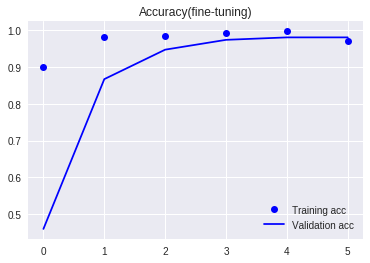

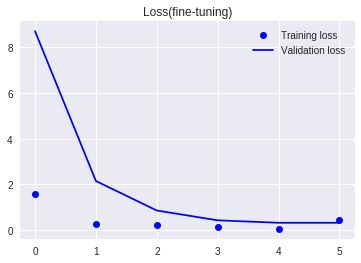

In [15]:
# plot the train process

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Accuracy(fine-tuning)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss(fine-tuning)')
plt.legend()

plt.show()

## Test the 11-20 picture for each class and my own face

In [0]:
probs = model.predict_generator(test_generator)
#probs = model.predict(test_data, 2, verbose=1)

In [17]:
true_y = np.array([0]*10+[1]*10)
preds_y = np.argmax(probs, axis=1)
compr = preds_y - true_y

# the image in the above problem which i recognized correctly
corr_img = np.where(compr == 0)[0]
corr_confidence = probs.max(axis=1)
list(zip(corr_img,corr_confidence[corr_img]))

[(0, 1.0),
 (1, 1.0),
 (2, 1.0),
 (3, 1.0),
 (4, 1.0),
 (5, 1.0),
 (6, 1.0),
 (7, 1.0),
 (8, 1.0),
 (9, 1.0),
 (10, 1.0),
 (11, 1.0),
 (12, 1.0),
 (13, 1.0),
 (14, 1.0),
 (15, 1.0),
 (16, 1.0),
 (17, 1.0),
 (18, 1.0),
 (19, 1.0)]

In [19]:
from google.colab import files
uploaded = files.upload()

Saving my_img.png to my_img.png


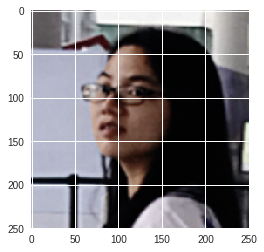

In [22]:
img = cv2.imread('my_img.png')
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [24]:
img = np.expand_dims(img,0)
prob = model.predict(img,verbose=1) # the second prediction 

# result
to_classes[np.argmax(prob)], prob.max(axis=1)[0]


1/1 [==============================] - 1s 636ms/step


('Jennifer', 1.0)

# 4. Adversarial Attack
Take one of Justin or Jennifer's test image in the above problem which you recognized correctly, and show that you can fool
the classifer by adding some unnoticeable noise.

## pick a correctly predicted test image

In [0]:
# test data to np.array

testdir = []
for class_k in os.listdir('test_dir'):
  for imgdir in os.listdir('test_dir/'+class_k):
    testdir.append('test_dir/'+class_k+'/'+imgdir)

    
test_data = [] 
for imgdir in testdir:
  img = cv2.imread(imgdir)
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  test_data.append(img)
  
test_data = np.stack(test_data, axis=0) 

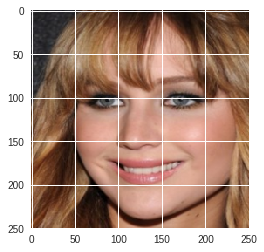

In [38]:
# pick an image in correcly-recognized image with index i=10
target_img_ind = corr_img[10]
target_img = test_data[target_img_ind]
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))


## noise

In [0]:
#! git clone https://github.com/Hyperparticle/one-pixel-attack-keras
#! cd ./one-pixel-attack-keras
#noise = np.random.normal(250, 0.1, (250,250,3))
#max(noise.flatten())

In [0]:
# adding an unnoticeable noise
noise = np.random.normal(0.1, 0.01, (250,250,3))

## attack

In [40]:
# attack
adversarial = cv2.resize(target_img, (IMG_SIZE, IMG_SIZE))
adversarial = (adversarial + noise)/255.
adversarial = np.expand_dims(adversarial,0)
snd_prob = model.predict(adversarial,verbose=1) # the second prediction 

# result
fst_pred = to_classes[preds_y[target_img_ind]], corr_confidence[target_img_ind]
snd_pred = to_classes[np.argmax(snd_prob)], snd_prob.max(axis=1)[0]
print(fst_pred[0], snd_pred[0])

1/1 [==============================] - 0s 33ms/step
Jennifer Justin


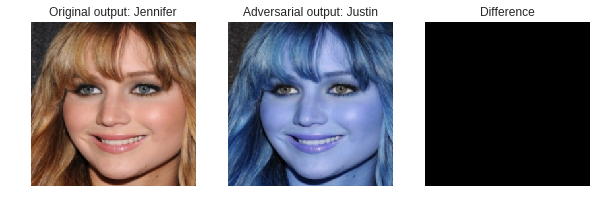

In [41]:
plt.figure(figsize=[10,15])

plt.subplot(1, 3, 1)
plt.title('Original output: '+ fst_pred[0])
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.axis('off')


plt.subplot(1, 3, 2)
plt.title('Adversarial output: '+ snd_pred[0] )
plt.imshow(adversarial[0])
# plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
plt.imshow(noise/255.)
plt.axis('off')

plt.show()